# Setup

In [ ]:
import pandas as pd
from torch.utils.data import DataLoader
import numpy as np
import random
import torch
import math
import os
from datetime import datetime
import json
import tensorflow as tf
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.layers import concatenate
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from keras.layers import Conv1D, Dense, Embedding, GlobalMaxPooling1D, Input, MaxPooling1D
from nltk.tokenize import RegexpTokenizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import spacy
import pickle
from tqdm import tqdm
from keras import backend as K

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive/faks/nn/dataset/WikiQACorpus/WikiQACorpus

[Errno 2] No such file or directory: 'drive/MyDrive/faks/nn/dataset/WikiQACorpus/WikiQACorpus'
/content/drive/MyDrive/faks/nn/dataset/WikiQACorpus/WikiQACorpus


In [ ]:
train_dataset_path = 'WikiQA-train.tsv'
dev_dataset_path = 'WikiQA-dev.tsv'

In [ ]:
MAX_VOCAB_SIZE = 30000
EMBEDDING_DIM_300 = 300
MAX_SEQUENCE_LENGTH_GLOVE = 75
GLOVE_EMBEDDING_TRAINABLE = True
MAX_SEQUENCE_LENGTH = 75
callbacks = [ModelCheckpoint("question_answer_weights.h5", monitor='val_loss', save_best_only=True)]

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "tagger", "tok2vec", "attribute_ruler"])

In [ ]:
def tokenize(data, save_path):
    return get_words_per_docs(data, save_path, nlp)

def parse_data(df: pd.DataFrame) -> tuple:
    questions = df['Question'].tolist()
    answers = df['Sentence'].tolist()
    labels = df['Label'].tolist()
    return questions, answers, [float(l) for l in labels]

def read_pickle(path):
    with open(path, "rb") as file:
        return pickle.load(file)


def write_pickle(path, obj):
    with open(path, "wb") as file:
        pickle.dump(obj, file)

def is_token_valid(token):
    return (
        not token.is_punct
        and not token.is_stop
        and not token.like_email
        and not token.is_currency
        and not token.is_quote
        and not token.is_bracket
        and not token.is_space
        and not token.like_num
        and not token.is_digit
    )

def get_words_per_docs(docs, words_per_doc_path, nlp):
    if os.path.isfile(words_per_doc_path):
        print("loading...")
        words_per_doc = read_pickle(words_per_doc_path)
        print("loaded")
    else:
        print("processing...")
        words_per_doc = []
        for text in tqdm(docs):
            doc = nlp(text)
            tmp = []
            for token in doc:
                if is_token_valid(token):
                    tmp.append(token.lemma_.lower())
            words_per_doc.append(tmp)

        write_pickle(words_per_doc_path, words_per_doc)
        print("processed")

    return words_per_doc

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    return f1_score(tf.make_ndarray(y_true.op.get_attr('value')), tf.make_ndarray(y_pred.op.get_attr('value')), average='macro')

# Read data

Glove

In [ ]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.6B.300d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


Dataset

In [ ]:
df_train = pd.read_csv(train_dataset_path, delimiter='\t')
df_dev = pd.read_csv(dev_dataset_path, delimiter='\t')

questions_train, answers_train, labels_train = parse_data(df_train)
questions_dev, answers_dev, labels_dev = parse_data(df_dev)

In [ ]:
questions_train_tokenized = tokenize(questions_train, "questions_train_tokenized_no_numbers.pkl")
answers_train_tokenized = tokenize(answers_train, "answers_train_tokenized_no_numbers.pkl")
questions_dev_tokenized = tokenize(questions_dev, "questions_dev_tokenized_no_numbers.pkl")
answers_dev_tokenized = tokenize(answers_dev, "answers_dev_tokenized_no_numbers.pkl")

processing...


  0%|          | 0/20355 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████| 20355/20355 [00:01<00:00, 13093.03it/s]


processed
processing...


100%|██████████| 20355/20355 [00:05<00:00, 3411.69it/s]


processed
processing...


100%|██████████| 2733/2733 [00:00<00:00, 14246.57it/s]


processed
processing...


100%|██████████| 2733/2733 [00:00<00:00, 4128.01it/s]

processed


In [ ]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(questions_train_tokenized + answers_train_tokenized)

questions_train_sequences = tokenizer.texts_to_sequences(questions_train_tokenized)
answers_train_sequences = tokenizer.texts_to_sequences(answers_train_tokenized)
questions_dev_sequences = tokenizer.texts_to_sequences(questions_dev_tokenized)
answers_dev_sequences = tokenizer.texts_to_sequences(answers_dev_tokenized)

questions_train_padded = pad_sequences(questions_train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
answers_train_padded = pad_sequences(answers_train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
questions_dev_padded = pad_sequences(questions_dev_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
answers_dev_padded = pad_sequences(answers_dev_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

Glove

In [ ]:
# create a weight matrix for words in training docs
MAX_VOCAB_SIZE = len(tokenizer.word_index.items())+1
embedding_matrix = np.zeros((MAX_VOCAB_SIZE, EMBEDDING_DIM_300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM_300, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH_GLOVE, trainable=GLOVE_EMBEDDING_TRAINABLE)

### temp

In [ ]:
def get_questions_dictionary(df: pd.DataFrame) -> dict:
    # fill dictionary
    questions_dictionary = {}
    for idx, row in df_train.iterrows():
        if row['Question'] not in questions_dictionary:
            questions_dictionary[row['Question']] = []
        questions_dictionary[row['Question']].append((row['Sentence'], row['Label']))

    # remove questions without answers
    keys_to_remove = []
    
    for key, value in questions_dictionary.items():
        flag = False
        for item in value:
            if item[1] == 1.0:
                flag = True
                break
        if not flag:
            keys_to_remove.append(key)

    for key in keys_to_remove:
        del questions_dictionary[key]

    return questions_dictionary

class Example:
    question: str = None
    answer: str = None
    sentences = list = None

    def __init__(self, question, answer, sentences):
        self.question = question
        self.answer = answer
        self.sentences = sentences

def generate_examples(questions_dictionary):
    for key, value in questions_dictionary.items():
        valid_answers = [candidate[0] for candidate in value if candidate[1] == 1.0]
        invalid_answers = [candidate[0] for candidate in value if candidate[1] == 0.0]
        if len(invalid_answers) == 0:
            continue
        for answer in valid_answers:
            yield Example(key, answer, invalid_answers)

# Train

simple embedding layer

In [ ]:
'''
EMBEDDING_DIM = 100
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    input_length=MAX_SEQUENCE_LENGTH,
)
embedding_layer_answer = Embedding(
    num_words_answer,
    EMBEDDING_DIM,
    input_length=MAX_SEQUENCE_LENGTH,
)
'''

'\nEMBEDDING_DIM = 100\nembedding_layer = Embedding(\n    num_words,\n    EMBEDDING_DIM,\n    input_length=MAX_SEQUENCE_LENGTH,\n)\nembedding_layer_answer = Embedding(\n    num_words_answer,\n    EMBEDDING_DIM,\n    input_length=MAX_SEQUENCE_LENGTH,\n)\n'

In [ ]:
y_categorical_train = tf.keras.utils.to_categorical(
    labels_train, num_classes=2, dtype='float32'
)

y_categorical_dev = tf.keras.utils.to_categorical(
    labels_dev, num_classes=2, dtype='float32'
)

network

In [ ]:
seed_value = 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

In [ ]:
EPOCHS = 15
BATCH_SIZE = 32
class_weight = {0: 1.,
                1: 10.}

input_q = Input(shape=(MAX_SEQUENCE_LENGTH,))
input_a = Input(shape=(MAX_SEQUENCE_LENGTH,))
q = embedding_layer(input_q)
a = embedding_layer(input_a)
# --------------------------------------

q = Conv1D(256, 3, activation="relu")(q)
q = MaxPooling1D(3)(q)
q = Conv1D(128, 3, activation="relu")(q)
q = GlobalMaxPooling1D()(q)

a = Conv1D(256, 3, activation="relu")(a)
a = MaxPooling1D(3)(a)
a = Conv1D(128, 3, activation="relu")(a)
a = GlobalMaxPooling1D()(a)

merged = concatenate([q, a])
merged = Dense(128, activation="relu")(merged)

output = Dense(2, activation="softmax")(merged)

model = Model([input_q, input_a], output)
model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=0.0001),
    metrics=["binary_accuracy"],
)


early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
r = model.fit(
    [questions_train_padded, answers_train_padded],
    y_categorical_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=([questions_dev_padded, answers_dev_padded], y_categorical_dev),
    class_weight=class_weight
)

Epoch 1/15
637/637 [==============================] - 9s 13ms/step - loss: 0.9077 - binary_accuracy: 0.8841 - val_loss: 0.4682 - val_binary_accuracy: 0.8610
Epoch 2/15
637/637 [==============================] - 8s 12ms/step - loss: 0.7247 - binary_accuracy: 0.8861 - val_loss: 0.4669 - val_binary_accuracy: 0.7995
Epoch 3/15
637/637 [==============================] - 8s 12ms/step - loss: 0.4822 - binary_accuracy: 0.9168 - val_loss: 0.2992 - val_binary_accuracy: 0.8961
Epoch 4/15
637/637 [==============================] - 8s 13ms/step - loss: 0.2350 - binary_accuracy: 0.9628 - val_loss: 0.2774 - val_binary_accuracy: 0.9067
Epoch 5/15
637/637 [==============================] - 8s 12ms/step - loss: 0.1054 - binary_accuracy: 0.9848 - val_loss: 0.3037 - val_binary_accuracy: 0.9005
Epoch 6/15
637/637 [==============================] - 8s 13ms/step - loss: 0.0541 - binary_accuracy: 0.9925 - val_loss: 0.2873 - val_binary_accuracy: 0.9349


# Evaluate

In [ ]:
p = model.predict([questions_train_padded, answers_train_padded])
y_pred_train = []
for prediction in p:
    y_pred_train.append(np.argmax(prediction, axis=0))

In [ ]:
print(confusion_matrix(labels_train, y_pred_train))

[[19231    84]
 [    0  1040]]


In [ ]:
print(classification_report(labels_train, y_pred_train))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     19315
         1.0       0.93      1.00      0.96      1040

    accuracy                           1.00     20355
   macro avg       0.96      1.00      0.98     20355
weighted avg       1.00      1.00      1.00     20355



In [ ]:
print(f1_score(labels_train, y_pred_train, average="macro"))

0.9795018900048174


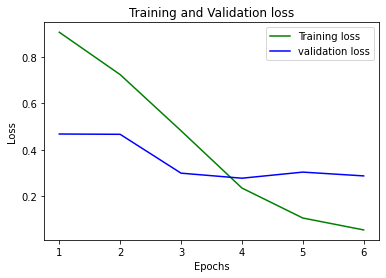

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

loss_train = r.history['loss']
loss_val = r.history['val_loss']
epochs = range(1,early_stopping.stopped_epoch+2)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
p = model.predict([questions_dev_padded, answers_dev_padded])
y_dev_pred = []
for prediction in p:
    y_dev_pred.append(np.argmax(prediction, axis=0))

In [ ]:
print(confusion_matrix(labels_dev, y_dev_pred))

[[2533   60]
 [ 118   22]]


In [ ]:
print(classification_report(labels_dev, y_dev_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      2593
         1.0       0.27      0.16      0.20       140

    accuracy                           0.93      2733
   macro avg       0.61      0.57      0.58      2733
weighted avg       0.92      0.93      0.93      2733



In [ ]:
print(f1_score(labels_dev, y_dev_pred, average="macro"))

0.582127321829839
